In [1]:
import torch
import random
import numpy as np
import os

In [2]:
# Set random seed
SEED = 2021
random.seed(SEED)
np.random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)  # type: ignore
torch.backends.cudnn.deterministic = True  # type: ignore
torch.backends.cudnn.benchmark = True  # type: ignore

## PyTorch Dataset

```python
from torch.utils.data.dataset import Dataset

class MyCustomDataset(Dataset):
    def __init__(self, ...):
        # stuff
        
    def __getitem__(self, index):
        # stuff
        return (img, label)

    def __len__(self):
        return count # of how many examples(images?) you have
```

This is the skeleton that you have to fill to have a custom dataset. 
A dataset must contain following functions to be used by data loader later on.

* \_\_init\_\_() function is where the initial logic happens like reading a csv, assigning transforms, filtering data, etc.
* \_\_getitem\_\_() function returns the data and labels. This function is called from dataloader like this:
    img, label = MyCustomDataset.__getitem__(99)  # For 99th item  
* \_\_getitem\_\_() returns a specific type for a single data point (like a tensor, numpy array etc.), 
    otherwise, in the data loader you will get an error
* \_\_len\_\_() returns count of samples you have

In [3]:
import torch
from torch.utils.data.dataset import Dataset
from sklearn.datasets import load_iris

In [4]:
class IrisDataset(Dataset):
    def __init__(self):
        iris = load_iris()
        self.X = iris['data']
        self.y = iris['target']
        
        self.feature_names = iris['feature_names']
        self.target_names = iris['target_names']

    def __len__(self):
        len_dataset = None
        len_dataset = len(self.X)
        return len_dataset

    def __getitem__(self, idx):
        X, y = None, None
        X = torch.tensor(self.X[idx],dtype=torch.float)
        y = torch.tensor(self.y[idx],dtype=torch.long)
        return X, y
    

In [5]:
dataset_iris = IrisDataset()

In [6]:
dataset_iris[0]

(tensor([5.1000, 3.5000, 1.4000, 0.2000]), tensor(0))

## Map-style datasets
- A map-style dataset is one that implements the \_\_getitem\_\_() and \_\_len\_\_() protocols, and represents a map from (possibly non-integral) indices/keys to data samples.
- For example, such a dataset, when accessed with dataset[idx], could read the idx-th image and its corresponding label from a folder on the disk.

## Iterable-style datasets
- An iterable-style dataset is an instance of a subclass of IterableDataset that implements the \_\_iter\_\_() protocol, and represents an iterable over data samples. This type of datasets is particularly suitable for cases where random reads are expensive or even improbable, and where the batch size depends on the fetched data.

- For example, such a dataset, when called iter(dataset), could return a stream of data reading from a database, a remote server, or even logs generated in real time.

## PyTorch DataLoader

```python
DataLoader(dataset, 
           batch_size=1, 
           shuffle=False, 
           sampler=None,
           batch_sampler=None, 
           num_workers=0, 
           collate_fn=None,
           pin_memory=False, 
           drop_last=False, 
           timeout=0,
           worker_init_fn=None)
```

### dataset
    -  dataset from which to load the data.

### batch_size
    - how many samples per batch to load (default: 1).

### shuffle
    - set to True to have the data reshuffled at every epoch (default: False).

### sampler
    - defines the strategy to draw samples from the dataset. Can be any Iterable with __len__ implemented. If specified, shuffle must not be specified.

- Map-style datasets. torch.utils.data.Sampler classes are used to specify the sequence of indices/keys used in data loading. They represent iterable objects over the indices to datasets. E.g., in the common case with stochastic gradient decent (SGD), a Sampler could randomly permute a list of indices and yield each one at a time, or yield a small number of them for mini-batch SGD.

- A sequential or shuffled sampler will be automatically constructed based on the shuffle argument to a DataLoader. Alternatively, users may use the sampler argument to specify a custom Sampler object that at each time yields the next index/key to fetch.

- A custom Sampler that yields a list of batch indices at a time can be passed as the batch_sampler argument. Automatic batching can also be enabled via batch_size and drop_last arguments. See the next section for more details on this.

- Neither sampler nor batch_sampler is compatible with iterable-style datasets, since such datasets have no notion of a key or an index.

```python
# SequentialSampler : Samples elements sequentially, always in the same order.

# RandomSampler : Samples elements randomly. If without replacement, then sample from a shuffled dataset. If with replacement, then user can specify num_samples to draw.

# SubsetRandomSampler : Samples elements randomly from a given list of indices, without replacement.

# WeightedRandomSampler : Samples elements from [0,..,len(weights)-1] with given probabilities (weights)
list(WeightedRandomSampler([0.1, 0.9, 0.4, 0.7, 3.0, 0.6], 5, replacement=True))

# BatchSampler : Wraps another sampler to yield a mini-batch of indices.
list(BatchSampler(SequentialSampler(range(10)), batch_size=3, drop_last=False))

# DistributedSampler : Sampler that restricts data loading to a subset of the dataset.
# It is especially useful in conjunction with torch.nn.parallel.DistributedDataParallel. In such a case, each process can pass a DistributedSampler instance as a DataLoader sampler, and load a subset of the original dataset that is exclusive to it.

sampler = DistributedSampler(dataset) if is_distributed else None
loader = DataLoader(dataset, shuffle=(sampler is None),
                    sampler=sampler)
for epoch in range(start_epoch, n_epochs):
    if is_distributed:
        sampler.set_epoch(epoch)
    train(loader)
```

### batch_sampler (Sampler or Iterable, optional) 
    – like sampler, but returns a batch of indices at a time. Mutually exclusive with batch_size, shuffle, sampler, and drop_last.

### num_workers (int, optional) 
    – how many subprocesses to use for data loading. 0 means that the data will be loaded in the main process. (default: 0)

### collate_fn (callable, optional) 
    – merges a list of samples to form a mini-batch of Tensor(s). Used when using batched loading from a map-style dataset.

In [7]:
from torch.utils.data import DataLoader

class RandomDataset(Dataset):
    def __init__(self, tot_len=10, n_features=1):
        self.X = torch.rand((tot_len, n_features))
        self.y = torch.randint(0, 3, size=(tot_len, ))  

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = torch.FloatTensor(self.X[idx])
        y = self.y[idx]
        return x, y

In [8]:
dataset_random = RandomDataset(tot_len=10)

In [9]:
def collate_fn(batch):
    print('Original:\n', batch)
    print('-'*100)
    
    data_list, label_list = [], []
    
    for _data, _label in batch:
        data_list.append(_data)
        label_list.append(_label)
    
    print('Collated:\n', [torch.Tensor(data_list), torch.LongTensor(label_list)])
    print('-'*100)
    
    return torch.Tensor(data_list), torch.LongTensor(label_list)

In [10]:
next(iter(DataLoader(dataset_random, collate_fn=collate_fn, batch_size=4)))

Original:
 [(tensor([0.1304]), tensor(2)), (tensor([0.5134]), tensor(0)), (tensor([0.7426]), tensor(0)), (tensor([0.7159]), tensor(0))]
----------------------------------------------------------------------------------------------------
Collated:
 [tensor([0.1304, 0.5134, 0.7426, 0.7159]), tensor([2, 0, 0, 0])]
----------------------------------------------------------------------------------------------------


(tensor([0.1304, 0.5134, 0.7426, 0.7159]), tensor([2, 0, 0, 0]))

### pin_memory (bool, optional) 
    – If True, the data loader will copy Tensors into CUDA pinned memory before returning them. If your data elements are a custom type, or your collate_fn returns a batch that is a custom type, see the example below.

### drop_last (bool, optional) 
    – set to True to drop the last incomplete batch, if the dataset size is not divisible by the batch size. If False and the size of dataset is not divisible by the batch size, then the last batch will be smaller. (default: False)

### timeout (numeric, optional) 
    – if positive, the timeout value for collecting a batch from workers. Should always be non-negative. (default: 0)

### worker_init_fn (callable, optional) 
– If not None, this will be called on each worker subprocess with the worker id (an int in [0, num_workers - 1]) as input, after seeding and before data loading. (default: None)

## torchvision.transform

In [11]:
from torchvision import transforms
import torchvision

### transforms.Resize
    - Resize the input image to the given size. If the image is torch Tensor, it is expected to have […, H, W] shape, where … means an arbitrary number of leading dimensions

### transforms.RandomCrop
    - Crop the given image at a random location. If the image is torch Tensor, it is expected to have […, H, W] shape, where … means an arbitrary number of leading dimensions, but if non-constant padding is used, the input is expected to have at most 2 leading dimensions

### transforms.RandomRotation
    - Rotate the image by angle. If the image is torch Tensor, it is expected to have […, H, W] shape, where … means an arbitrary number of leading dimensions.

### transforms.ToTensor
    - Convert a PIL Image or numpy.ndarray to tensor. This transform does not support torchscript.

### transforms.ToPILImage
    - Convert a tensor or an ndarray to PIL Image. This transform does not support torchscript. 
    - Converts a torch.*Tensor of shape C x H x W or a numpy ndarray of shape H x W x C to a PIL Image while preserving the value range.

### transforms.Compose
    - Composes several transforms together. This transform does not support torchscript. Please, see the note below.
    
```python
transforms.Compose([
 transforms.CenterCrop(10),
 transforms.PILToTensor(),
 transforms.ConvertImageDtype(torch.float),
])
```

In [12]:
transform = transforms.Compose([transforms.Resize((224,224)),
                    transforms.RandomVerticalFlip(0.5),
                    transforms.CenterCrop(150)])

In [13]:
dataset_train_MNIST = torchvision.datasets.MNIST('data/MNIST/', # 다운로드 경로 지정
                                                 train=True, # True를 지정하면 훈련 데이터로 다운로드
                                                 transform=transforms.ToTensor(), # 텐서로 변환
                                                 download=True, 
                                                )

In [14]:
transform2 = transforms.Compose([transforms.RandomHorizontalFlip(),
                    transforms.ToTensor(),
                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [15]:
dataset_train_CIFAR10 = torchvision.datasets.CIFAR10(root='data/CIFAR10/',  # 다운로드 경로 지정
                                                     train=True,  # True를 지정하면 훈련 데이터로 다운로드
                                                     transform= transform2
                                                     ,  # 텐서로 변환
                                                     download=True,
                                                     )

Files already downloaded and verified


In [16]:
dataset_train_CIFAR10


Dataset CIFAR10
    Number of datapoints: 50000
    Root location: data/CIFAR10/
    Split: Train
    StandardTransform
Transform: Compose(
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [17]:
dataloader_train_CIFAR10 = DataLoader(dataset=dataset_train_CIFAR10,
                                      batch_size=16,
                                      shuffle=True,
                                      num_workers=4,
                                      )

In [18]:
images, labels = next(iter(dataloader_train_CIFAR10))

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt

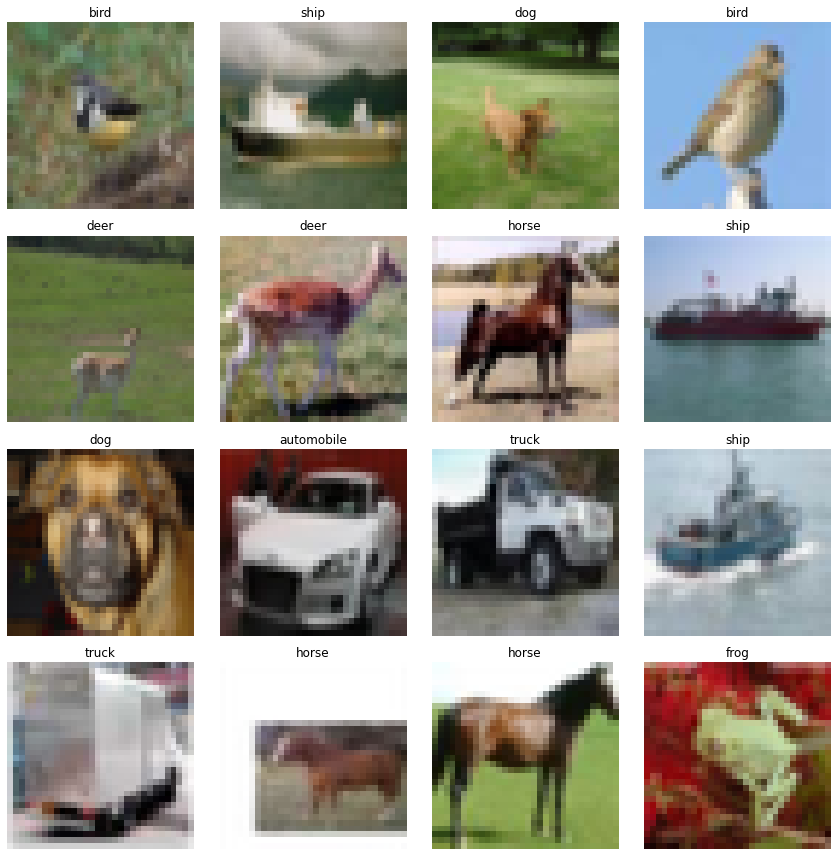

In [20]:
plt.figure(figsize=(12,12))
for n, (image, label) in enumerate(zip(images, labels), start=1):
    plt.subplot(4,4,n)
    plt.imshow(transforms.ToPILImage()(image*0.5+0.5))
    plt.title("{}".format(dataset_train_CIFAR10.classes[label]))
    plt.axis('off')
plt.tight_layout()
plt.show()    

# Overall View

```python
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader 
from network import CustomNet
from dataset import ExampleDataset
from loss import ExampleLoss

# Define Model
model = CustomNet()


# Define optimizer
params = [param for param in model.parameters() if param.requires_grad]
optimizer = optim.Example(params, lr=lr)

# Define loss
loss_fn = ExampleLoss()

##########################################################
##########################################################
# Define Dataset
class ExampleDataset(Dataset):
    def __init__(self, ...):
        # stuff
        
    def __getitem__(self, index):
        # stuff
        return (img, label)

    def __len__(self):
        return count 
dataset_example = ExampleDataset()

# Define Data loader
dataloader_example = DataLoader(dataset_example)
##########################################################
##########################################################

model.train()
for e in range(epochs):
    for X,y in dataloader_example:
        output = model(X)
        loss = loss_fn(output, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
```